In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#stylesheet for matplotlib
import matplotlib.patheffects as path_effects
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
#Import first 3 datasets to fulfil first objective
directory='./Original_Datasets/'
df1 = pd.read_csv(directory + 'bus_routes.csv', sep=',',na_values=['-','NaN'])
df2 = pd.read_csv(directory + "bus_stops.csv", sep=",",na_values=['-','NaN'])
df3 = pd.read_csv(directory + "bus_services.csv", sep=",",na_values=['-','NaN'])
#Drop the indexes of the main datasets
df1=df1.drop(['Unnamed: 0'],axis=1)
df2=df2.drop(['Unnamed: 0'], axis=1)
df3=df3.drop(['Unnamed: 0'], axis=1)
# print(df1.columns)
# print(df2.columns)
# print(df3.columns)

#Perform an inner merge for bus_routes and bus_services tables
merged1=pd.merge(df1, df3, how='inner', on=['ServiceNo','Operator','Direction'])
#Convert type of BusStopCode column in bus_routes tables to integer
df1["BusStopCode"]=df1["BusStopCode"].astype(int)
#Perform an inner merge for all 3 bus datasets
merged1=pd.merge(merged1, df2, how='inner', on=['BusStopCode'])

#Set indexes for the merged dataset1
merged1=merged1.set_index(["ServiceNo","Direction","StopSequence"])
#Sort the values according to ServiceNo, Direction & StopSequence in ascending order
merged1=merged1.sort_index(level=["ServiceNo","Direction","StopSequence"])

#Number of null values & type in the dataset before inputation
# print(merged1.isnull().sum())
# display(merged1.dtypes)
# display(merged1)
#Fill up missing values with 0
merged1=merged1.fillna(0)
# print(merged1.isnull().sum())
# display(merged1)

#Function to retrieve the first element in each data cell value
def second_element(data):
    if type(data)!=int and "-" in data:
        data=data.split("-")
        data=data[0]
        return data
    else:
        return data

#Apply the function across these columns
merged1[["AM_Peak_Freq","AM_Offpeak_Freq","PM_Peak_Freq","PM_Offpeak_Freq"]]=merged1[["AM_Peak_Freq","AM_Offpeak_Freq","PM_Peak_Freq","PM_Offpeak_Freq"]].applymap(second_element)

#Change types of columns
merged1[["AM_Peak_Freq","AM_Offpeak_Freq","PM_Peak_Freq","PM_Offpeak_Freq","OriginCode","DestinationCode"]]=merged1[["AM_Peak_Freq","AM_Offpeak_Freq","PM_Peak_Freq","PM_Offpeak_Freq","OriginCode","DestinationCode"]].astype(int)

#Drop columns
merged1=merged1.drop(["Latitude","Longitude","WD_FirstBus","WD_LastBus","SAT_FirstBus","SAT_LastBus","SUN_FirstBus","SUN_LastBus", "LoopDesc"], axis=1)

#Check the regex of every row of Description Column to see if the bus stop is an interchange or not and
#replace it with Has Interchange if it matches, N otherwise
merged1["Interchange"] = np.where(merged1["Description"].str.contains(r'Int$', regex=True), 'Has Interchange', 'Does Not Have Interchange')

#Formulate 2 new columns based on frequency of buses dispatched during peak vs non-peak period
column1=np.floor((merged1["AM_Peak_Freq"] + merged1["PM_Peak_Freq"])/2)
column2=np.floor((merged1["AM_Offpeak_Freq"] + merged1["PM_Offpeak_Freq"])/2)
merged1=merged1.assign(Freq_of_Buses_during_Peak_Period=column1,Freq_of_Buses_during_OffPeak_Period=column2)

#Drop final unused columns
merged1=merged1.drop(["Operator","AM_Peak_Freq","AM_Offpeak_Freq","PM_Peak_Freq","PM_Offpeak_Freq","OriginCode","DestinationCode","BusStopCode","RoadName"], axis=1)

print("Nature of Cleaned Dataset 1")
display(merged1.dtypes)

#Save cleaned dataset 1 as csv format
merged1.to_csv('./Cleaned_Datasets/merged_dataset1.csv')
display(merged1.head())
# display(merged1.tail())

Nature of Cleaned Dataset 1


Distance                               float64
Category                                object
Description                             object
Interchange                             object
Freq_of_Buses_during_Peak_Period       float64
Freq_of_Buses_during_OffPeak_Period    float64
dtype: object

Distance Category           Description  \
ServiceNo Direction StopSequence                                            
10        1         1                  0.0    TRUNK          Tampines Int   
                    2                  0.6    TRUNK  Opp Our Tampines Hub   
                    3                  1.1    TRUNK               Blk 147   
                    4                  2.3    TRUNK   Changi General Hosp   
                    5                  2.7    TRUNK          Opp Blk 3012   

                                                Interchange  \
ServiceNo Direction StopSequence                              
10        1         1                       Has Interchange   
                    2             Does Not Have Interchange   
                    3             Does Not Have Interchange   
                    4             Does Not Have Interchange   
                    5             Does Not Have Interchange   

                                  Freq_of_Buses_during_Peak_Period  \
ServiceNo Direction StopSequence                                     
10        1         1                                          9.0   
                    2                                          9.0   
                    3                                          9.0   
                    4                                          9.0   
                    5                                          9.0   

                                  Freq_of_Buses_during_OffPeak_Period  
ServiceNo Direction StopSequence                                       
10        1         1                                             8.0  
                    2                                             8.0  
                    3                                             8.0  
                    4                                             8.0  
                    5                                             8.0

,Category,Distance,Interchange
0,TRUNK,31.7,Has Interchange
1,TRUNK,31.9,Has Interchange
2,TRUNK,23.6,Has Interchange
3,TRUNK,23.3,Has Interchange
4,TRUNK,4.7,Has Interchange
...,...,...,...
656,TRUNK,1.8,Has Interchange
657,TRUNK,3.0,Has Interchange
658,TRUNK,8.4,Has Interchange
659,TRUNK,5.4,Has Interchange


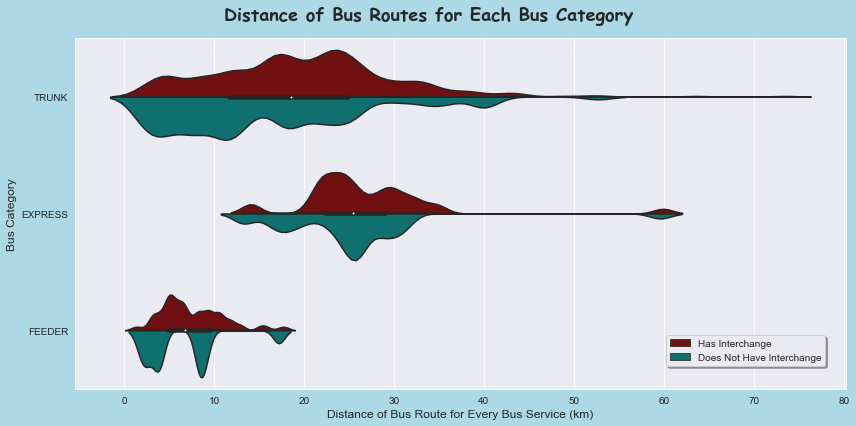

In [3]:
#Filter rows of data that Category matches only Trunk, Feeder, Express
specific_category=merged1[merged1["Category"].isin(["TRUNK","FEEDER","EXPRESS"])]

#Get maximum distance of route from every bus service number & direction
max_dist_of_everybusserviceNo=[]
unique_serviceno=specific_category.index.get_level_values(0).unique()
for unique_service in unique_serviceno:
    first_lvl_index1=specific_category[specific_category.index.get_level_values(0)==unique_service]
    second_lvl_index1=first_lvl_index1.index.get_level_values(1).unique()
    for index in second_lvl_index1:
        result=specific_category.loc[(unique_service,index)][["Category","Distance","Interchange"]].max()
        temp_dict={'Category':result["Category"], "Distance":result["Distance"], "Interchange":result["Interchange"]}
        max_dist_of_everybusserviceNo.append(temp_dict)

#Convert list to pandas dataframe
ds1 = pd.concat([pd.DataFrame([row], columns=["Category","Distance","Interchange"]) for row in max_dist_of_everybusserviceNo], ignore_index=True)
display(ds1)

#Plot Graph 1 (Violin Plot)
sns.set_style('darkgrid')
sns.set_palette('Accent')
fig1=plt.figure(1, figsize=(12,6))
fig1.set_facecolor("lightblue")
#bw=.14 shows how reduced the smoothness of the plots are
ax1=sns.violinplot(data=ds1, x='Distance', y='Category',bw=.14, hue="Interchange", split=True, palette=["maroon","teal"])
#overlay stripplot on violinplot
#sns.stripplot(data=ds1, x='Distance', y='Category',hue="Interchange", edgecolor="white", size=4, ax=ax1, palette=["blue", "darkgray"]) #jitter=True
legend = ax1.legend(loc='lower right', shadow=True, fancybox=True, bbox_to_anchor=(0.98, 0.05))
plt.xlabel("Distance of Bus Route for Every Bus Service (km)", fontsize=12)
plt.ylabel('Bus Category', fontsize=12)
fig1.suptitle('Distance of Bus Routes for Each Bus Category',fontsize=18, fontweight="heavy", fontfamily='cursive')
plt.tight_layout()
plt.show()

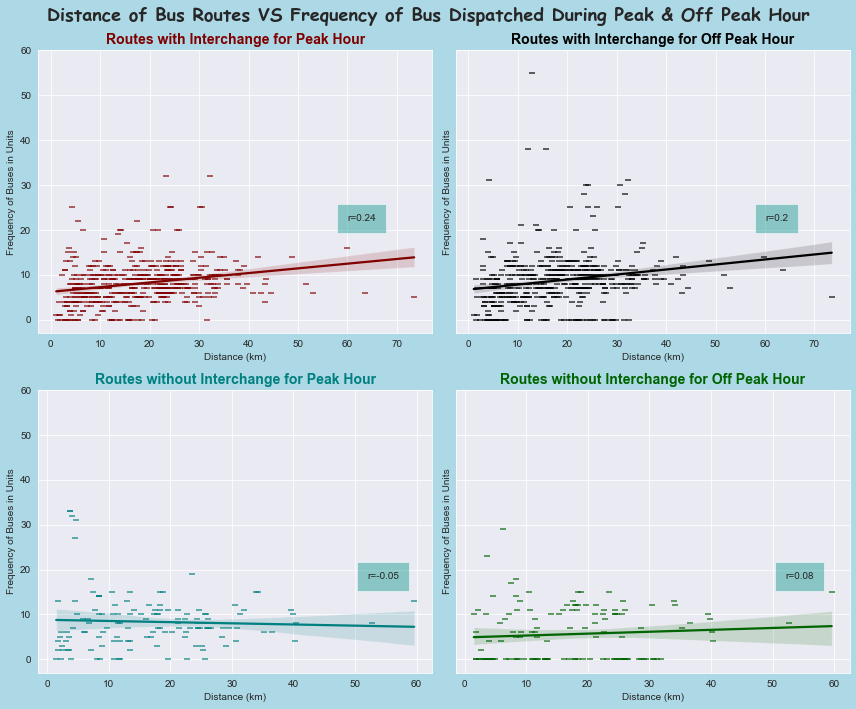

In [4]:
#Filter rows of data that Category matches only Trunk, Feeder, Express
specific_category=merged1[merged1["Category"].isin(["TRUNK","FEEDER","EXPRESS"])]

# 1) Get maximum distance of route from every bus service number & direction
# 2) Get frequency of buses dispatched for routes that contains bus interchange and no bus interchange
freq_Bus_wInterchange=[]
freq_Bus_wNoInterchange=[]
unique_serviceno=specific_category.index.get_level_values(0).unique()
for unique_service in unique_serviceno:
    #Obtain unique service for every bus route
    first_lvl_index1=specific_category[specific_category.index.get_level_values(0)==unique_service]
    #Obtain unique direction for every bus service
    second_lvl_index1=first_lvl_index1.index.get_level_values(1).unique()
    for index in second_lvl_index1:
        result=specific_category.loc[(unique_service,index)][["Category","Freq_of_Buses_during_Peak_Period","Freq_of_Buses_during_OffPeak_Period","Distance","Interchange"]].max()
        if result["Interchange"]=="Has Interchange":
            temp_dict1={'Category':result["Category"],"Freq_of_Buses_during_Peak_Period":result["Freq_of_Buses_during_Peak_Period"],"Freq_of_Buses_during_OffPeak_Period":result["Freq_of_Buses_during_OffPeak_Period"] ,"Distance":result["Distance"], "Interchange":result["Interchange"]}
            freq_Bus_wInterchange.append(temp_dict1)
        else:
            temp_dict2={'Category':result["Category"],"Freq_of_Buses_during_Peak_Period":result["Freq_of_Buses_during_Peak_Period"],"Freq_of_Buses_during_OffPeak_Period":result["Freq_of_Buses_during_OffPeak_Period"] ,"Distance":result["Distance"], "Interchange":result["Interchange"]}
            freq_Bus_wNoInterchange.append(temp_dict2)

#Convert list to pandas dataframe
ds2_1 = pd.concat([pd.DataFrame([row], columns=["Category","Freq_of_Buses_during_Peak_Period","Freq_of_Buses_during_OffPeak_Period","Distance","Interchange"]) for row in freq_Bus_wInterchange], ignore_index=True)
ds2_2 = pd.concat([pd.DataFrame([row], columns=["Category","Freq_of_Buses_during_Peak_Period","Freq_of_Buses_during_OffPeak_Period","Distance","Interchange"]) for row in freq_Bus_wNoInterchange], ignore_index=True)

#Plot Graph 2 (Scatterplots)
fig2,axes=plt.subplots(nrows=2,ncols=2, figsize=(12,10), sharey=True)
fig2.set_facecolor("lightblue")
sns.set_style('darkgrid')
ax2_1=sns.regplot(data=ds2_1, x="Distance", y="Freq_of_Buses_during_Peak_Period",ax=axes[0,0], color='maroon', marker="_")
ax2_2=sns.regplot(data=ds2_1, x="Distance", y="Freq_of_Buses_during_OffPeak_Period",ax=axes[0,1], color='black', marker="_")
ax2_3=sns.regplot(data=ds2_2, x="Distance", y="Freq_of_Buses_during_Peak_Period",ax=axes[1,0], color="teal", marker="_")
ax2_4=sns.regplot(data=ds2_2, x="Distance", y="Freq_of_Buses_during_OffPeak_Period",ax=axes[1,1], color='darkgreen', marker="_")
plt.ylim(-3,60)

ax2_1.set_title('Routes with Interchange for Peak Hour', fontweight='bold', color='maroon', fontsize=14)
ax2_1.set_xlabel("Distance (km)")
ax2_1.set_ylabel("Frequency of Buses in Units")
ax2_2.set_title('Routes with Interchange for Off Peak Hour', fontweight='bold',color='black', fontsize=14)
ax2_2.set_xlabel("Distance (km)")
ax2_2.set_ylabel("Frequency of Buses in Units")
ax2_3.set_title('Routes without Interchange for Peak Hour', fontweight='bold', color='teal', fontsize=14)
ax2_3.set_xlabel("Distance (km)")
ax2_3.set_ylabel("Frequency of Buses in Units")
ax2_4.set_title('Routes without Interchange for Off Peak Hour', fontweight='bold', color='darkgreen', fontsize=14)
ax2_4.set_xlabel("Distance (km)")
ax2_4.set_ylabel("Frequency of Buses in Units")
fig2.suptitle('Distance of Bus Routes VS Frequency of Bus Dispatched During Peak & Off Peak Hour',fontsize=18, fontweight="heavy",fontfamily='cursive')

#Get correlation coefficient of each relationship
corelation_coeff1 = np.corrcoef(ds2_1["Distance"], ds2_1["Freq_of_Buses_during_Peak_Period"])[0,1**2]
corelation_coeff2 = np.corrcoef(ds2_1["Distance"], ds2_1["Freq_of_Buses_during_OffPeak_Period"])[0,1**2]
corelation_coeff3 = np.corrcoef(ds2_2["Distance"], ds2_2["Freq_of_Buses_during_Peak_Period"])[0,1**2]
corelation_coeff4 = np.corrcoef(ds2_2["Distance"], ds2_2["Freq_of_Buses_during_OffPeak_Period"])[0,1**2]
string1="r="+str(round(corelation_coeff1,2))
string2="r="+str(round(corelation_coeff2,2))
string3="r="+str(round(corelation_coeff3,2))
string4="r="+str(round(corelation_coeff4,2))
#Insert text of correlation coefficient with a box as a background
ax2_1.text(60,22, string1, fontsize=10,bbox={'facecolor':'#2aa198', 'alpha':0.5, 'pad':10})
ax2_2.text(60,22, string2, fontsize=10,bbox={'facecolor':'#2aa198', 'alpha':0.5, 'pad':10})
ax2_3.text(52,18, string3, fontsize=10,bbox={'facecolor':'#2aa198', 'alpha':0.5, 'pad':10})
ax2_4.text(52,18, string4, fontsize=10,bbox={'facecolor':'#2aa198', 'alpha':0.5, 'pad':10})
plt.tight_layout()
plt.show()


In [5]:
#Filter rows of data that Category matches only Trunk, Feeder, Express
specific_category=merged1[merged1["Category"].isin(["TRUNK","FEEDER","EXPRESS"])]

#Get maximum distance of route from every bus service number & direction to collect frequency of buses dispatched 
#For each individual bus route and direction (both peak hour and non-peak hour)
max_freqOfBusDispatched_peakhr=[]
# max_freqOfBusDispatched_peakhrWOut_Int=[]
max_freqOfBusDispatched_offpeakhr=[]
# max_freqOfBusDispatched_offpeakhrWOut_Int=[]
unique_serviceno=specific_category.index.get_level_values(0).unique()
for unique_service in unique_serviceno:
    first_lvl_index1=specific_category[specific_category.index.get_level_values(0)==unique_service]
    second_lvl_index1=first_lvl_index1.index.get_level_values(1).unique()
    for index in second_lvl_index1:
        result1=specific_category.loc[(unique_service,index)][["Category","Freq_of_Buses_during_Peak_Period","Distance","Interchange"]].max()
        result2=specific_category.loc[(unique_service,index)][["Category","Freq_of_Buses_during_OffPeak_Period","Distance","Interchange"]].max()
        temp_dict1={'Category':result1["Category"], "Distance":result1["Distance"], "Freq_of_Buses_during_Peak_Period":result1["Freq_of_Buses_during_Peak_Period"],"Interchange":result1["Interchange"]}
        temp_dict2={'Category':result2["Category"], "Distance":result2["Distance"], "Freq_of_Buses_during_OffPeak_Period":result2["Freq_of_Buses_during_OffPeak_Period"],"Interchange":result2["Interchange"]}
        max_freqOfBusDispatched_peakhr.append(temp_dict1)
        max_freqOfBusDispatched_offpeakhr.append(temp_dict2)

#Convert list to pandas dataframe
ds1 = pd.concat([pd.DataFrame([row], columns=["Category","Freq_of_Buses_during_Peak_Period","Distance","Interchange"]) for row in max_freqOfBusDispatched_peakhr], ignore_index=True)
ds2 = pd.concat([pd.DataFrame([row], columns=["Category","Freq_of_Buses_during_OffPeak_Period","Distance","Interchange"]) for row in max_freqOfBusDispatched_offpeakhr], ignore_index=True)

print("Peak Period")
display(ds1)
print("Off-Peak Period")
display(ds2)

#Create the figures
fig3=make_subplots(rows=1,cols=2)
fig3.add_trace(go.Box(
    y=ds1[ds1["Category"]=="TRUNK"]["Freq_of_Buses_during_Peak_Period"],
    x=ds1[ds1["Category"]=="TRUNK"]["Interchange"],
    name='Trunk',
    marker_color='teal'
), row=1, col=1)
fig3.add_trace(go.Box(
    y=ds1[ds1["Category"]=="EXPRESS"]["Freq_of_Buses_during_Peak_Period"],
    x=ds1[ds1["Category"]=="EXPRESS"]["Interchange"],
    name='Express',
    marker_color='maroon'
), row=1, col=1)
fig3.add_trace(go.Box(
    y=ds1[ds1["Category"]=="FEEDER"]["Freq_of_Buses_during_Peak_Period"],
    x=ds1[ds1["Category"]=="FEEDER"]["Interchange"],
    name='Feeder',
    marker_color='black'
), row=1, col=1)


fig3.add_trace(go.Box(
    y=ds2[ds2["Category"]=="TRUNK"]["Freq_of_Buses_during_OffPeak_Period"],
    x=ds2[ds2["Category"]=="TRUNK"]["Interchange"],
    marker_color='teal',
    showlegend=False
), row=1, col=2)
fig3.add_trace(go.Box(
    y=ds2[ds2["Category"]=="EXPRESS"]["Freq_of_Buses_during_OffPeak_Period"],
    x=ds2[ds2["Category"]=="EXPRESS"]["Interchange"],
    marker_color='maroon',
    showlegend=False
), row=1, col=2)
fig3.add_trace(go.Box(
    y=ds2[ds2["Category"]=="FEEDER"]["Freq_of_Buses_during_OffPeak_Period"],
    x=ds2[ds2["Category"]=="FEEDER"]["Interchange"],
    marker_color='black',
    showlegend=False
), row=1, col=2)

#Group together boxes for each value of x
fig3.update_layout(
    boxmode='group',
)

#Create the dropdown
dropdown_buttons=[
    {'label':'All','method':'update','args':[{'visible':[True, True, True]},{'title':'Frequency of All Buses Dispatched for Peak Hour & Non-Peak Hour'}]},
    {'label':'Trunk','method':'update','args':[{'visible':[True, False, False]},{'title':'Frequency of Trunk Buses Dispatched for Peak Hour & Non-Peak Hour'}]},
    {'label':'Express','method':'update','args':[{'visible':[False, True, False]},{'title':'Frequency of Express Buses Dispatched for Peak Hour & Non-Peak Hour'}]},
    {'label':'Feeder','method':'update','args':[{'visible':[False, False,True]},{'title':'Frequency of Feeder Buses Dispatched for Peak Hour & Non-Peak Hour'}]}
]

#Add dropdown to the figure
fig3.update_layout({
    'updatemenus':[{
        'type':'dropdown',
        'x':1.1,
        'y':0.6,
        'showactive':True,
        'active':0,
        'buttons':dropdown_buttons
    }]
})

fig3.update_yaxes(range=[-2, 36], title_text="Average Frequency of All Buses Dispatched", title=dict(font=dict(size=10)))
fig3.update_xaxes(title_text='Interchange',title=dict(font=dict(size=10)))
fig3.update_layout(annotations=[
        dict(text='Peak Hour', x=0.18, xref='paper', y=1.10, yref='paper', align='center', showarrow=False, font=dict(size=15)),
        dict(text='Off-Peak Hour', x=0.77, xref='paper', y=1.1, yref='paper', align='center', showarrow=False, xanchor='center', xshift=0.5, font=dict(size=15))
    ],title='Frequency of All Buses Dispatched for Peak Hour & Non-Peak Hour')
fig3.show()

Peak Period


,Category,Freq_of_Buses_during_Peak_Period,Distance,Interchange
0,TRUNK,9.0,31.7,Has Interchange
1,TRUNK,9.0,31.9,Has Interchange
2,TRUNK,6.0,23.6,Has Interchange
3,TRUNK,7.0,23.3,Has Interchange
4,TRUNK,15.0,4.7,Has Interchange
...,...,...,...,...
656,TRUNK,0.0,1.8,Has Interchange
657,TRUNK,0.0,3.0,Has Interchange
658,TRUNK,0.0,8.4,Has Interchange
659,TRUNK,10.0,5.4,Has Interchange


Off-Peak Period


,Category,Freq_of_Buses_during_OffPeak_Period,Distance,Interchange
0,TRUNK,8.0,31.7,Has Interchange
1,TRUNK,11.0,31.9,Has Interchange
2,TRUNK,9.0,23.6,Has Interchange
3,TRUNK,9.0,23.3,Has Interchange
4,TRUNK,10.0,4.7,Has Interchange
...,...,...,...,...
656,TRUNK,7.0,1.8,Has Interchange
657,TRUNK,9.0,3.0,Has Interchange
658,TRUNK,17.0,8.4,Has Interchange
659,TRUNK,0.0,5.4,Has Interchange


In [6]:
directory='./Original_Datasets/'
df5 = pd.read_csv(directory + 'trains_raillength_and_buses_travel_distance.csv', sep=',',na_values=['na','-'])
df5= df5.drop(['Rail Length (Kilometres)','Average Daily Ridership - Bus (Thousand Passenger-Trips)','Average Daily Trip - Point-To-Point (P2P) Transport (Taxis And Private Hire Cars) (Thousand Daily-Trips)'], axis=1)
df5=df5.rename(columns={"Data Series":"Year", "Rail Length -> Mass Rapid Transit (MRT) (Kilometres)":"Rail Length (MRT)","Rail Length -> Light Rail Transit (LRT) (Kilometres)":"Rail Length (LRT)", "MRT km Operated (Thousand Train-Kilometres)":"Average Daily Distance (MRT)", "LRT km Operated (Thousand Car-Kilometres)":"Average Daily Distance (LRT)","Average Daily Ridership - MRT (Thousand Passenger-Trips)":"Average Daily Ridership (MRT)","Average Daily Ridership - LRT (Thousand Passenger-Trips)":"Average Daily Ridership (LRT)"})
df5=df5.set_index(["Year"])
#Add a new role for 2004
df5.loc[2004]=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
df5=df5.sort_index()

#Cleaning dataset 3
#Fill up the missing data for rail length with linear method of interpolation
display(df5.isnull().sum())
display(df5)
df5[["Rail Length (MRT)","Rail Length (LRT)"]]=df5[["Rail Length (MRT)","Rail Length (LRT)"]].interpolate(limit_direction="both")
df5_1=df5.loc[2002:][["Rail Length (MRT)","Rail Length (LRT)"]]
#Round off rail length by 1d.p.
df5_1[["Rail Length (MRT)","Rail Length (LRT)"]]=df5_1[["Rail Length (MRT)","Rail Length (LRT)"]].applymap(lambda x: round(x,1))
display(df5_1)
print("Nature of Cleaned Dataset 2")
print(df5_1.dtypes)
print()
#Save cleaned dataset 2 as csv format
df5_1.to_csv('./Cleaned_Datasets/rail_length_of_trains.csv')

#Cleaning dataset 4
df5_2=df5.loc[2011:][["Average Daily Distance (MRT)","Average Daily Distance (LRT)","Average Daily Ridership (MRT)", "Average Daily Ridership (LRT)"]]
df5_2[["Average Daily Distance (MRT)","Average Daily Distance (LRT)","Average Daily Ridership (MRT)", "Average Daily Ridership (LRT)"]]=df5_2[["Average Daily Distance (MRT)","Average Daily Distance (LRT)","Average Daily Ridership (MRT)", "Average Daily Ridership (LRT)"]].astype(int)
df5_2[["Average Daily Distance (MRT)","Average Daily Distance (LRT)"]]=df5_2[["Average Daily Distance (MRT)","Average Daily Distance (LRT)"]].applymap(lambda x: round(x/365*1000,1))

display(df5_2)
print("Nature of Cleaned Dataset 3")
print(df5_2.dtypes)
#Save cleaned dataset 3 as csv format
df5_2.to_csv('./Cleaned_Datasets/daily_train_ridership_and_distance_covered.csv')

Rail Length (MRT)                 4
Rail Length (LRT)                 6
Average Daily Distance (MRT)     10
Average Daily Distance (LRT)     10
Average Daily Ridership (MRT)     6
Average Daily Ridership (LRT)     6
dtype: int64

,Rail Length (MRT),Rail Length (LRT),Average Daily Distance (MRT),Average Daily Distance (LRT),Average Daily Ridership (MRT),Average Daily Ridership (LRT)
Year,,,,,,
1990,67.0,NaN,NaN,NaN,NaN,NaN
1996,83.0,NaN,NaN,NaN,NaN,NaN
1999,83.0,7.8,NaN,NaN,NaN,NaN
2002,89.4,7.8,NaN,NaN,NaN,NaN
2003,109.4,18.5,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN,NaN
2005,109.4,28.8,NaN,NaN,1321.0,69.0
2006,NaN,NaN,NaN,NaN,1408.0,74.0
2007,NaN,NaN,NaN,NaN,1527.0,79.0


,Rail Length (MRT),Rail Length (LRT)
Year,,
2002,89.4,7.8
2003,109.4,18.5
2004,109.4,23.6
2005,109.4,28.8
2006,111.8,28.8
2007,114.2,28.8
2008,116.5,28.8
2009,118.9,28.8
2010,129.9,28.8


Nature of Cleaned Dataset 2
Rail Length (MRT)    float64
Rail Length (LRT)    float64
dtype: object



,Average Daily Distance (MRT),Average Daily Distance (LRT),Average Daily Ridership (MRT),Average Daily Ridership (LRT)
Year,,,,
2011,61547.9,9917.8,2295,111
2012,72580.8,10638.4,2525,124
2013,72383.6,12150.7,2623,132
2014,77186.3,13115.1,2762,137
2015,78890.4,16265.8,2871,153
2016,93682.2,18137.0,3095,180
2017,99391.8,19816.4,3122,190
2018,111506.8,20005.5,3302,199
2019,112008.2,20728.8,3384,208


Nature of Cleaned Dataset 3
Average Daily Distance (MRT)     float64
Average Daily Distance (LRT)     float64
Average Daily Ridership (MRT)      int32
Average Daily Ridership (LRT)      int32
dtype: object


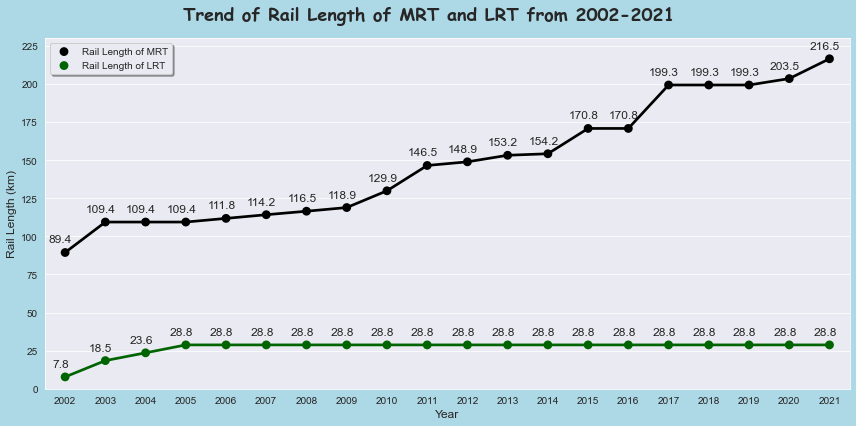

In [7]:
#Plot Graph 4 (Point Plot)
sns.set_style('darkgrid')
fig4=plt.figure(1, figsize=(12,6))
fig4.set_facecolor("lightblue")
ax4=sns.pointplot(data=df5_1, x=df5_1.index, y="Rail Length (MRT)", color="black", label="Rail Length of MRT")
ax4=sns.pointplot(data=df5_1, x=df5_1.index, y="Rail Length (LRT)", color="darkgreen", label="Rail Length of LRT")
plt.ylim(0,230)
plt.yticks(range(0,226,25))
fig4.suptitle('Trend of Rail Length of MRT and LRT from 2002-2021',fontsize=18, fontweight="heavy", fontfamily='cursive')
legend = ax4.legend(loc='upper left', shadow=True, fancybox=True)
plt.xlabel("Year", fontsize=12)
plt.ylabel('Rail Length (km)', fontsize=12)

#Annotate rail length values in the each respective pointplot
#Offset points in textcoords will have the annotations placed respective to the points plotted
for i, point in enumerate(ax4.collections[0].get_offsets()):
    ax4.annotate(str(point[1]), (point[0]-0.11, point[1]), textcoords='offset points', xytext=(0,10), ha="center", fontsize=12)
for i, point in enumerate(ax4.collections[1].get_offsets()):
    ax4.annotate(str(point[1]), (point[0]-0.11, point[1]), textcoords='offset points', xytext=(0,10), ha="center", fontsize=12)
plt.tight_layout()
plt.show()

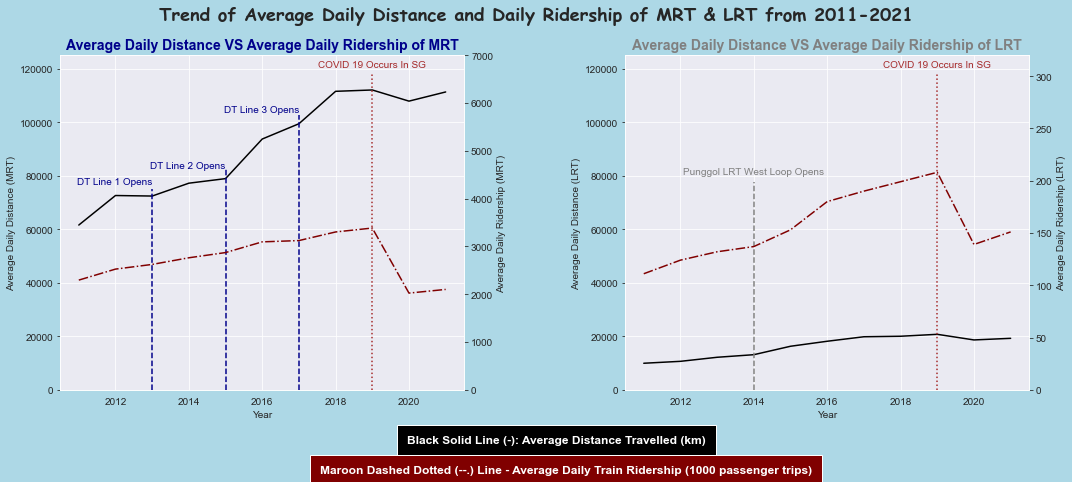

In [8]:
#Plot Graph 5 (Double Axis Line Plots)
fig5,(axes1, axes2)=plt.subplots(nrows=1,ncols=2, figsize=(15,6))
fig5.set_facecolor("lightblue")
#First subplot
sns.lineplot(data=df5_2, x=df5_2.index, y="Average Daily Distance (MRT)", color="black", label="Distance Travelled by MRT (km)", ax=axes1, linestyle="solid")
axes1.set_ylim(0,125000)
fig5.align_xlabels(df5_2.index)
#Add a second y-axis to the first subplot
ax1=axes1.twinx()
sns.lineplot(data=df5_2, x=df5_2.index, y="Average Daily Ridership (MRT)", color="maroon", label="Average Daily MRT Ridership (1000 passenger trips)", ax=ax1, linestyle="dashdot")
ax1.set_ylim(0,7000)
axes1.set_title('Average Daily Distance VS Average Daily Ridership of MRT', fontweight='bold', color='darkblue', fontsize=14)
axes1.get_legend().remove()
ax1.get_legend().remove()

#Second subplot
sns.lineplot(data=df5_2, x=df5_2.index, y="Average Daily Distance (LRT)", color="black", label="Distance Travelled by LRT (km)", ax=axes2, linestyle="solid")
axes2.set_ylim(0,125000)
#Add a second y-axis to the second subplot
ax2=axes2.twinx()
sns.lineplot(data=df5_2, x=df5_2.index, y="Average Daily Ridership (LRT)", color="maroon", label="Average Daily LRT Ridership (1000 passenger trips)", ax=ax2, linestyle="dashdot")
ax2.set_ylim(0,320)
axes2.set_title('Average Daily Distance VS Average Daily Ridership of LRT', fontweight='bold', color='grey', fontsize=14)
fig5.suptitle('Trend of Average Daily Distance and Daily Ridership of MRT & LRT from 2011-2021',fontsize=18, fontweight="heavy", fontfamily='cursive')
axes2.get_legend().remove()
ax2.get_legend().remove()
string1="Black Solid Line (-): Average Distance Travelled (km)"
fig5.text(0.38, -0.03, string1, fontsize=12,bbox={'facecolor':'black', 'pad':10}, color='white', fontweight='bold')
string2="Maroon Dashed Dotted (--.) Line - Average Daily Train Ridership (1000 passenger trips)"
fig5.text(0.3, -0.1, string2, fontsize=12,bbox={'facecolor':'maroon','pad':10}, color='white', fontweight='bold')

axes1.axvline(x=2019, color='brown', linestyle=':', ymax=0.95)
axes1.text(2019, 120000, 'COVID 19 Occurs In SG', ha='center', va='bottom', color='brown')
axes1.axvline(x=2013, color='darkblue', linestyle='--', ymax=0.60)
axes1.text(2013, 76000, 'DT Line 1 Opens', ha='right', va='bottom', color='darkblue')
axes1.axvline(x=2015, color='darkblue', linestyle='--', ymax=0.66)
axes1.text(2015, 82000, 'DT Line 2 Opens', ha='right', va='bottom', color='darkblue')
axes1.axvline(x=2017, color='darkblue', linestyle='--', ymax=0.82)
axes1.text(2017, 103200, 'DT Line 3 Opens', ha='right', va='bottom', color='darkblue')

axes2.axvline(x=2014, color='grey', linestyle='--', ymax=0.62)
axes2.text(2014, 80000, 'Punggol LRT West Loop Opens', ha='center', va='bottom', color='grey')
axes2.axvline(x=2019, color='brown', linestyle=':', ymax=0.95)
axes2.text(2019, 120000, 'COVID 19 Occurs In SG', ha='center', va='bottom', color='brown')
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()
#Increase margin to the right of each subplot
plt.subplots_adjust(wspace=0.40)
plt.show()

In [9]:
directory='./Original_Datasets/'
df6 = pd.read_json(directory+'dist_travelled_before_5min_or_more_mrtdelays.json')
# display(df6.head())
df6=df6.set_index(["year"])
display(df6.head())
print("Nature of Cleaned Dataset 4")
print(df6.dtypes)
#Save cleaned dataset 4 as csv format
df6.to_csv('./Cleaned_Datasets/mrt_dist_travelled_before_majorDelays.csv')

#Plot Graph 6 (Grouped Bar Chart)
data=[
go.Bar(x=df6.index,y=df6["North-South Line"], name="North South Line", marker=dict(color='crimson')),
go.Bar(x=df6.index,y=df6["East-West Line"], name="East-West Line",marker=dict(color='teal')),
go.Bar(x=df6.index,y=df6["North-East Line"], name="North-East Line",marker=dict(color='indigo')),
go.Bar(x=df6.index,y=df6["Circle Line"], name="Circle Line",marker=dict(color='#B58B00')),
go.Bar(x=df6.index,y=df6["Downtown Line"], name="Downtown Line",marker=dict(color='darkblue'))
]
layout=go.Layout(title='Distance Travelled By All MRT Lines Before Major Delays', barmode='group',
xaxis=dict(title='Year', title_font=dict(size=14), tickmode="array", tickvals=df6.index), yaxis=dict(title="Distance (km)",title_font=dict(size=14), tickmode="array", tickvals=[i for i in range(0,9300000,1000000)]))
fig6=go.Figure(data, layout)

#Create the dropdown
my_buttons=[
    {'label':'All','method':'update','args':[{'visible':[True, True, True, True,True]},{'title':'Distance Travelled By All MRT Lines Before Major Delays'}]},
    {'label':'North-South Line','method':'update','args':[{'visible':[True, False, False, False, False]},{'title':'Distance Travelled By North-South Line Before Major Delays'}]},
    {'label':'East-West Line','method':'update','args':[{'visible':[False, True, False, False, False]},{'title':'Distance Travelled By East-West Line Before Major Delays'}]},
    {'label':'North-East Line','method':'update','args':[{'visible':[False, False,True, False, False]},{'title':'Distance Travelled By North-East Line Before Major Delays'}]},
    {'label':'Circle Line','method':'update','args':[{'visible':[False, False,False, True, False]},{'title':'Distance Travelled By Circle Line Before Major Delays'}]},
    {'label':'Downtown Line','method':'update','args':[{'visible':[False, False,False, False, True]},{'title':'Distance Travelled By Downtown Line Before Major Delays'}]}
]

fig6.update_layout({
    'updatemenus':[{
        'type':'buttons',
        'direction':'down',
        'x':1.13,
        'y':0.62,
        'showactive':True,
        'active':0,
        'buttons':my_buttons
    }]
})

fig6.show()

,North-South Line,East-West Line,North-East Line,Circle Line,Downtown Line
year,,,,,
2018,894000,408000,1369000,728000,928000
2019,1429000,1483000,1377000,1215000,1136000
2020,1082000,1258000,2040000,1733000,2090000
2021,1976000,1454000,2064000,1826000,4188000
2022,3295000,1456000,2065000,2437000,8228000


Nature of Cleaned Dataset 4
North-South Line    int64
East-West Line      int64
North-East Line     int64
Circle Line         int64
Downtown Line       int64
dtype: object
